In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import NullLocator, LinearLocator, MultipleLocator, IndexLocator, FixedLocator, LogLocator, MaxNLocator
from matplotlib.ticker import NullFormatter, FormatStrFormatter, FuncFormatter, ScalarFormatter, FixedFormatter

# 1997 - 2006, 2009 - 2023 погода Рязань

# data
данные обновлены 29.11.2023
- t  - температура
- p  - давление
- cloud - облачность
- precip - осадки/гроза
- wdir - направление ветра
- ws - скорость ветра 
<br> метка **d** в конце названия столбца указывает что данные **дневные**
<br> метка **n** в конце названия столбца указывает что данные **ночные**

In [2]:
data = pd.read_csv('data.csv', index_col='id')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8912 entries, 0 to 8911
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     8912 non-null   int64  
 1   month    8912 non-null   int64  
 2   day      8912 non-null   int64  
 3   td       8897 non-null   float64
 4   pd       8897 non-null   float64
 5   cloudd   8888 non-null   object 
 6   precipd  1342 non-null   object 
 7   wdird    8897 non-null   object 
 8   wsd      8897 non-null   float64
 9   tn       8884 non-null   float64
 10  pn       8884 non-null   float64
 11  cloudn   8873 non-null   object 
 12  precipn  1189 non-null   object 
 13  wdirn    8884 non-null   object 
 14  wsn      8884 non-null   float64
dtypes: float64(6), int64(3), object(6)
memory usage: 1.1+ MB


**словари для меток осей**

In [3]:
dictmonth = {1: {'a': 'Ян', 'f': 'Январь'}, 2: {'a': 'Фе', 'f': 'Февраль'}, 
             3: {'a': 'Март', 'f': 'Март'}, 4: {'a': 'Ап', 'f': 'Апрель'},
             5: {'a': 'Май', 'f': 'Май'},   6: {'a': 'Июнь', 'f': 'Июнь'},
             7: {'a': 'Июль', 'f': 'Июль'}, 8: {'a': 'Ав', 'f': 'Август'},
             9: {'a': 'Се', 'f': 'Сентябрь'}, 10: {'a': 'Ок', 'f': 'Октябрь'},
            11: {'a': 'Но', 'f': 'Ноябрь'},   12: {'a': 'Де', 'f': 'Декабрь'}}

In [23]:
# данные дневного и ночного давления совпадают в 31.9% случаев
(data.pd == data.pn).mean()

0.31889587073608616

# 3. Давление

##### среднее и медианное давление

In [4]:
pmean = data[['pd', 'pn']].mean().round(2)
pmed = data[['pd', 'pn']].median()
print('среднее давление днем составляет:', pmean.loc['pd'], 'мм.рт.ст.,', 
      'медианное дневное давление:', pmed.loc['pd'],
     '\nсреднее давление ночью составляет:', pmean.loc['pn'], 'мм.рт.ст.,',
     'медианное ночное давление:', pmed.loc['pn'],)

среднее давление днем составляет: 747.38 мм.рт.ст., медианное дневное давление: 747.0 
среднее давление ночью составляет: 747.4 мм.рт.ст., медианное ночное давление: 747.0


###### минимальное и максимальное давление

In [5]:
pmin = data[['pd', 'pn']].min()
pmax = data[['pd', 'pn']].max()
print('показатель минимального дневного давления:', pmin['pd'], 'мм.рт.ст., ночного:', pmin['pn'],
     '\nмаксимальное зарегистрированное давление днем:', pmax['pd'], 'мм.рт.ст., ночное:', pmax['pn'])

показатель минимального дневного давления: 717.0 мм.рт.ст., ночного: 716.0 
максимальное зарегистрированное давление днем: 776.0 мм.рт.ст., ночное: 776.0


### 3.1 разницы между дневным и вечерним давлением

In [6]:
# добавляем столбец с разницей дневного и вечернего давления по модулю
data.insert(loc=data.shape[1], 
            column='pdiff', 
            value=data[['pd', 'pn']].apply(lambda row: abs(row['pd'] - row['pn']), axis=1))

In [7]:
# подсчет каждой дневной разницы давления 
count_pdiff = data.pdiff.value_counts().sort_index()
count_pdiff.index = pd.array(count_pdiff.index, dtype='int')

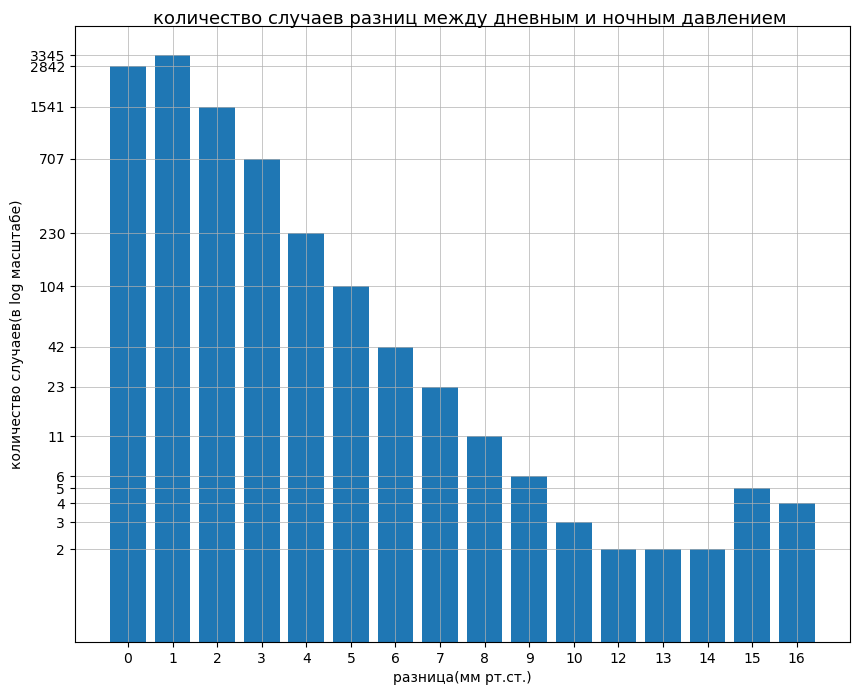

In [8]:
fig13 = plt.figure(figsize=(10, 8))
fig13.suptitle('количество случаев разниц между дневным и ночным давлением',x=0.52,y=0.90, fontsize=13)
ax_cpd = fig13.add_subplot()
ax_cpd.set_yscale('symlog', base=2)
ax_cpd.bar(x=np.arange(len(count_pdiff.index)), height=count_pdiff)
ax_cpd.set_xlabel('разница(мм рт.ст.)')
ax_cpd.set_ylabel('количество случаев(в log масштабе)')
ax_cpd.grid(which='major', lw=0.5)
ax_cpd.xaxis.set_major_locator(FixedLocator(np.arange(len(count_pdiff.index))))
ax_cpd.xaxis.set_major_formatter(FixedFormatter(count_pdiff.index))
ax_cpd.yaxis.set_major_locator(FixedLocator(np.unique(count_pdiff.sort_values().values)))
ax_cpd.yaxis.set_major_formatter(FixedFormatter(np.unique(count_pdiff.sort_values().values)))
ax_cpd.yaxis.set_minor_locator(NullLocator())
ax_cpd.tick_params(axis='y', which='major', labelsize=10);

### 3.2 межгодовая разница среднего дневного давления

In [9]:
#группируем данные
ygp = data.groupby('year').agg(pd_mean=('pd','mean'), pn_mean=('pn','mean')).round(2)
#новый фрейм с годами в index и columns
years_pdiff = pd.DataFrame(columns=np.unique(data.year), index=np.unique(data.year)[::-1])
#заполняем данными
for i in years_pdiff.index:
    for j in years_pdiff.columns:
        years_pdiff[i].loc[j] = ygp['pd_mean'].loc[i] - ygp['pd_mean'].loc[j]
years_pdiff = years_pdiff.astype('float')        

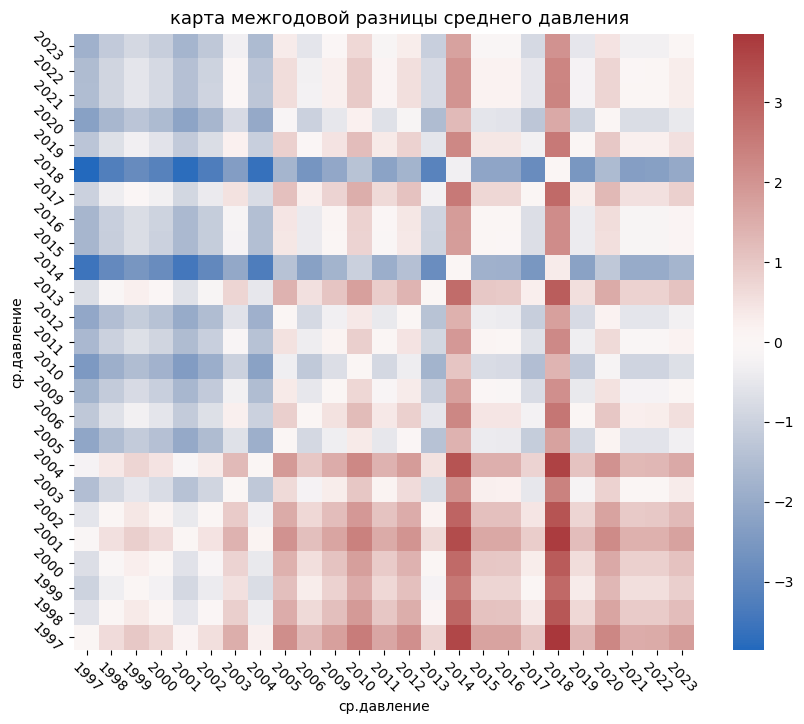

In [10]:
fig14 = plt.figure(figsize=(10, 8))
fig14.suptitle('карта межгодовой разницы среднего давления',x=0.45,y=0.91, fontsize=13)
ax_ypd = fig13.add_subplot()
ax_ypd = sns.heatmap(years_pdiff, cmap='vlag')
ax_ypd.tick_params(axis ='x', rotation = -45)
ax_ypd.tick_params(axis ='y', rotation = -45)
ax_ypd.set(xlabel="ср.давление", ylabel="ср.давление");

### 3.3 годовое среднее давление

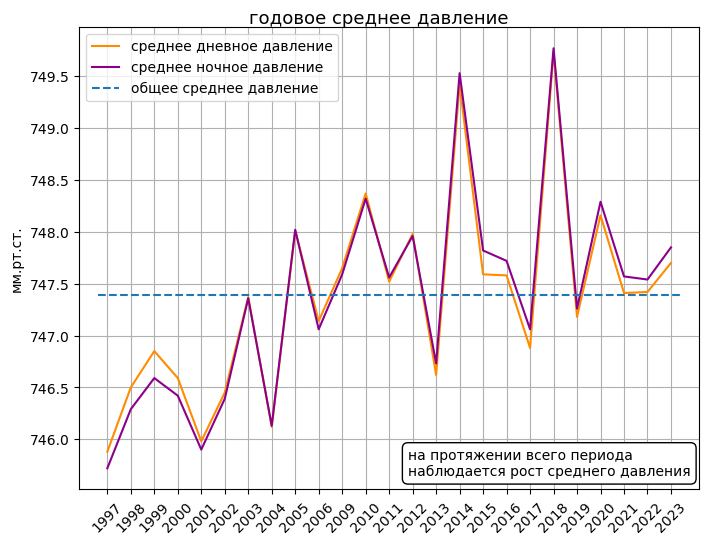

In [11]:
fig15 = plt.figure(figsize=(8, 6))
fig15.suptitle('годовое среднее давление',x=0.5,y=0.91, fontsize=13)
ax_ygp = fig15.add_subplot()
ax_ygp.plot(np.arange(len(ygp.index)), ygp['pd_mean'], label='среднее дневное давление', c='DarkOrange')
ax_ygp.plot(np.arange(len(ygp.index)), ygp['pn_mean'], label='среднее ночное давление', c='DarkMagenta')
ax_ygp.axhline(y=pmean.mean(), xmin=0.03, xmax=0.97, label='общее среднее давление', linestyle='--')
ax_ygp.xaxis.set_major_locator(FixedLocator(np.arange(len(ygp.index))))
ax_ygp.xaxis.set_major_formatter(FixedFormatter(ygp.index))
ax_ygp.tick_params(axis ='x', rotation = 45)
ax_ygp.legend(loc=2)
ax_ygp.set_ylabel('мм.рт.ст.')
ax_ygp.text(x=12.8, y=745.65, s='на протяжении всего периода\nнаблюдается рост среднего давления', 
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'))
ax_ygp.grid();

### 3.4 среднее давление по месяцам

In [12]:
# группировка давления по месяцам
mgp = data.groupby('month').agg(pd_mean=('pd','mean'), pn_mean=('pn','mean')).round(2)

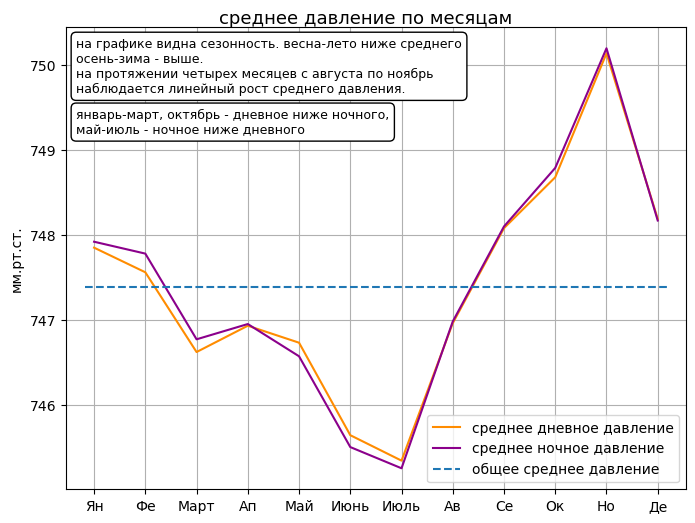

In [13]:
fig16 = plt.figure(figsize=(8, 6))
fig16.suptitle('среднее давление по месяцам',x=0.5,y=0.91, fontsize=13)
ax_mgp = fig16.add_subplot()
ax_mgp.plot(mgp['pd_mean'], label='среднее дневное давление', c='DarkOrange')
ax_mgp.plot(mgp['pn_mean'], label='среднее ночное давление', c='DarkMagenta')
ax_mgp.axhline(y=pmean.mean(), xmin=0.03, xmax=0.97, label='общее среднее давление', linestyle='--')
ax_mgp.xaxis.set_major_locator(FixedLocator(mgp.index))
ax_mgp.xaxis.set_major_formatter(FixedFormatter([dictmonth[i]['a'] for i in range(1, 13)]))
ax_mgp.legend(loc=4)
ax_mgp.set_ylabel('мм.рт.ст.')
ax_mgp.text(x=0.65, y=749.68, s='на графике видна сезонность. весна-лето ниже среднего\
\nосень-зима - выше. \
\nна протяжении четырех месяцев с августа по ноябрь\
\nнаблюдается линейный рост среднего давления.', 
            fontsize=9,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'))
ax_mgp.text(x=0.65, y=749.2, s='январь-март, октябрь - дневное ниже ночного,\nмай-июль - ночное ниже дневного', 
            fontsize=9,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'))
ax_mgp.grid();

### 3.5 количество случаев каждой зарегистрированной величины давления

In [14]:
#фрейм со всеми величинами давления и количество случаев величины для каждого времени суток 
count_p = data.melt(value_vars=['pd', 'pn'])
count_p = count_p.groupby(['variable', 'value']).agg(count=('value','count')).reset_index()
count_p = count_p.pivot(index='value', columns='variable', values='count').fillna(0).reset_index().astype('int')

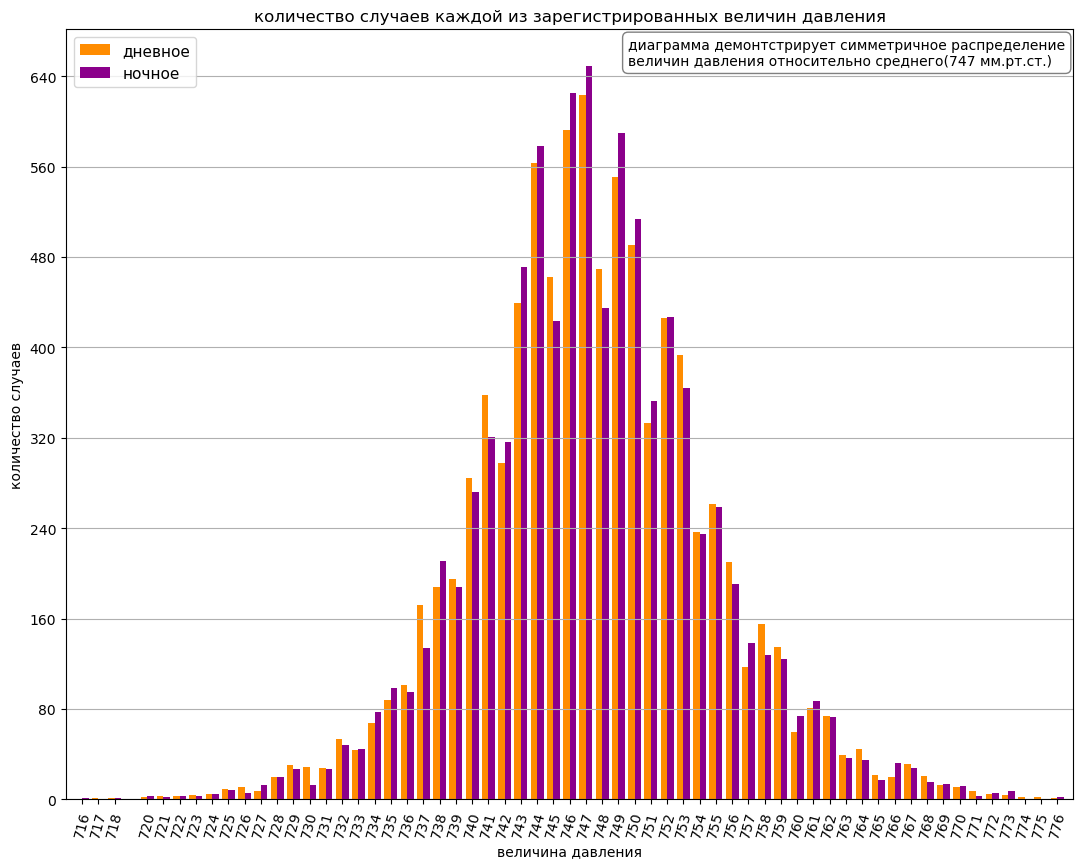

In [18]:
width = 0.4
fig17 = plt.figure(figsize=(13, 10))
ax_cp = fig17.add_subplot()
ax_cp.bar(count_p.value - width/2, height=count_p.pd, width=width, label='дневное', color='DarkOrange')
ax_cp.bar(count_p.value + width/2, height=count_p.pn, width=width, label='ночное', color='DarkMagenta')
ax_cp.set_title('количество случаев каждой из зарегистрированных величин давления', fontsize=12)
ax_cp.set_xticks(count_p['value'])
ax_cp.yaxis.set_major_locator(MaxNLocator(10))
ax_cp.tick_params(axis ='x', rotation = 75)
ax_cp.set_ylabel('количество случаев')
ax_cp.set_xlabel('величина давления')
ax_cp.legend(loc=2, fontsize=11)
ax_cp.grid(axis='y')
ax_cp.text(x=749.6, y=650, 
           s='диаграмма демонтстрирует симметричное распределение\nвеличин давления относительно среднего(747 мм.рт.ст.)', 
           bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round, pad=0.4'))
plt.xlim(pmin.min()-1, pmax.max()+1);

### 3.6 рассеивание суточных показателей

In [19]:
# подсчет суточных пар давления
vcp = data[['pd', 'pn']].value_counts().reset_index()

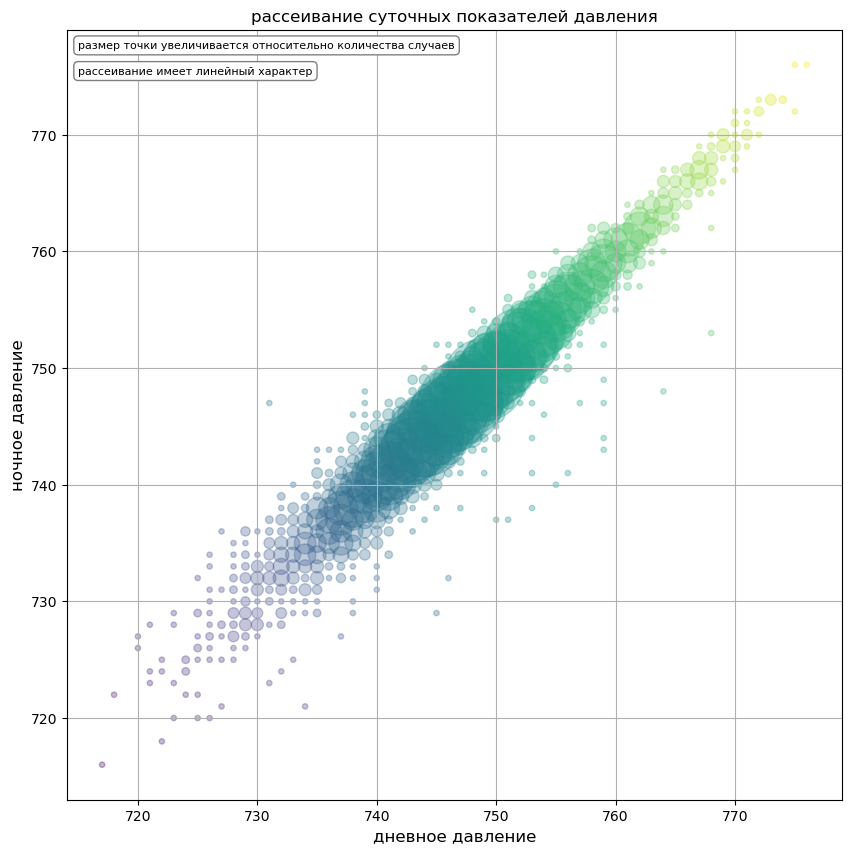

In [21]:
fig18 = plt.figure(figsize=(10, 10))
ax_vcp = fig18.add_subplot()
ax_vcp.scatter(vcp.pd, vcp.pn, s=vcp[0]*15, c=vcp.pd*vcp.pn, alpha=0.3)
ax_vcp.set_xlabel('дневное давление', fontsize=12)
ax_vcp.set_ylabel('ночное давление', fontsize=12)
ax_vcp.set_title('рассеивание суточных показателей давления')
ax_vcp.text(x=715, y=777.4, 
            s='размер точки увеличивается относительно количества случаев', 
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round, pad=0.4'),
            fontsize=8)
ax_vcp.text(x=715, y=775.2, 
            s='рассеивание имеет линейный характер', 
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round, pad=0.4'),
            fontsize=8)
ax_vcp.grid(); 